# SCIKIT-LEARN TUTORIALS FOR BEGINNERS

## PART 2 - EXPLORATORY DATA ANALYSIS


**CONTENTS**

- [Outliers - Introduction](#outliers_introduction)

- [Outlier Detection and Removal - Simple dataset 1](#detect_remove_numpy)
    + [Visualization](#Visualization)
    + [The Tuckey method](#Tuckey)
    + [Scikit-learn](#detect_remove_sklearn)
         + [Elliptic Envelope](#EllipticEnvelope)
         + [DBSCAN](#DBSCAN)
         + [Isolation Forest](#IsolationForest)
         + [Local Outlier Factor](#LocalOutlierFactor)
- [Example dataset 2 - Simple linear regression problem](#linear_regression)
- [Example dataset 3 - Multivariate outlier detection](#multivariate_outlier)

*** Note that in this tutorial, we just go through **the ways to remove the possible outliers and evaluate the result by visualization**. The other approaches for model performance evaluation such as using different metrics will be discussed in more detail in the other part of the tutorial.

<a id='outliers_introduction'></a>

## 1. OUTLIERS - INTRODUCTION

 Outliers are data points/samples having an unusual value with one or more variables.
 
#### TYPE OF OUTLIERS

- Outliers can be caused by sensor malfunction, data entry errors; which should be removed.
- Outliers from freak event => must be paid attention to and should not be omitted from the data.

#### BAD EFFECT OF OUTLIERS

- Problem for statistical analysis and modelling: Wrong prediction, worse inference
- Wrong data imputing, for example, outliers can greatly change the values of filled-missing data using the statistical method such as fillna by means.

#### HOW TO DETECT OUTLIERS

- For low dimension data:
    + Visualization with scatter plot, box plot
- For multivariate outliers
    + The Tuckey method
    + Scikit-learn ML techniques: Clustering algorithms (Isolation Forest, DBSCAN, Local Outlier Factor, Elliptic Envelope), Linear regression, etc. 
    
#### OVERVIEW OF SOME OUTLIER REMOVAL TECHNIQUES

- **The Tuckey Method**: applied on normal distributions
- **Elliptic Envelope (Gaussian model)**: Could be use for large dataset with many dimensions. Steps include:
     + Fit a Gaussian distribution on the data
     + Find values that have very low probability => can be considered anomalies using a set threshold.

- **DBSCAN (Density-Based Spatial Clustering of Applications with Noise)**: Need to tune the parameters to get the "good" cluster

- **Isolation Forest**: 
        + Good for high dimensional dataset. 
        + Need to tune the parameters to get the "good" cluster
    
- A good reference could be found [here](https://medium.com/learningdatascience/anomaly-detection-techniques-in-python-50f650c75aaf)

<a id='detect_remove_numpy'></a>

## 2. OUTLIER DETECTION AND REMOVAL - SIMPLE DATASET 1 

### 2.1. DEMO DATASET
- Dataset 1: 
    + Anomaly detection - supervised dataset from the file `data/anomaly_detection1.mat`.
    + Used this for teaching purpose: could see all the outliers on visualization.
    + X: 2 features X1 and X2, y: binary class (0: normal and 1: anomaly observations).

In [5]:
### import necessary packages
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io
import matplotlib.pyplot as plt

In [198]:
### Load and process the data
mat = scipy.io.loadmat('data/anomaly_detection1.mat')
#access data through mat['X'] (or mat['Xval']) and mat['y']
X = mat['X']
y = mat['yval']
print(X.shape, y.shape)
### Make the dataframe for easy visualization
data = pd.DataFrame(X, columns = ['X1', 'X2'])
data['y'] = y
data.head(3)

(307, 2) (307, 1)


,X1,X2,y
0,13.046815,14.741152,0
1,13.408520,13.763270,0
2,14.195915,15.853181,0


<a id='Visualization'></a>
### 2.2. OUTLIER DETECTION USING VISUALIZATION

- Plot with Seaborn package

#### SCATTER PLOT

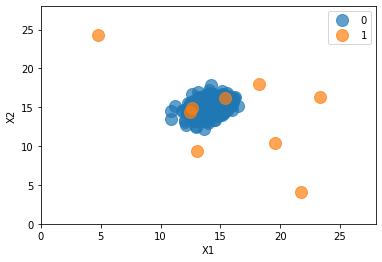

In [199]:
#### Way 1
# g = sns.FacetGrid(data = data, hue = 'y', height = 5) # Height (in inches) of each facet.
# g.map(plt.scatter, "X1", "X2", alpha = 0.8)
# g.add_legend()
# plt.show()

### Way 2
def plotScatter(data):
    groups = data.groupby('y')
    for name, group in groups:
        plt.plot(group.X1, group.X2, marker='o', linestyle='', markersize=12, label=name, alpha = 0.7)
    plt.legend()
    plt.xlim(0, 28)
    plt.ylim(0, 28)
    plt.xlabel('X1')
    plt.ylabel('X2')
    
plotScatter(data)    

#### PAIR PLOT

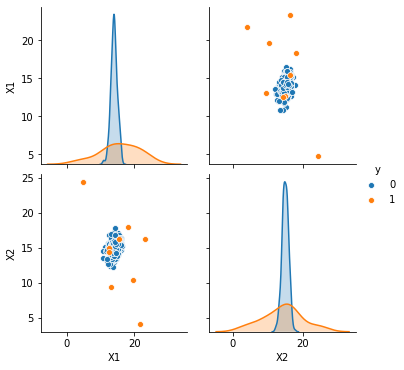

In [200]:
sns.pairplot(data, hue = 'y')
plt.show()

#### BOX PLOT ON EACH VARIABLE

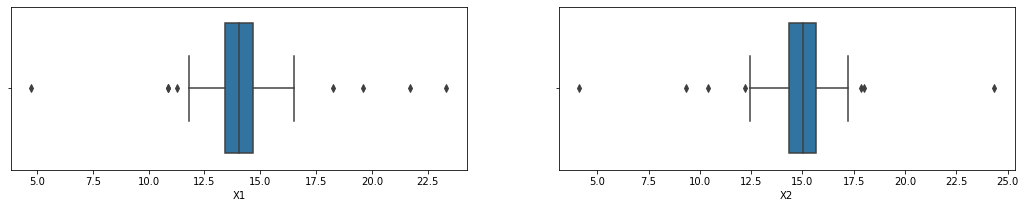

In [201]:
### boxplot => Check if data has outliers or not
fig = plt.figure(figsize = (18,3))
fig.add_subplot(1,2,1)
sns.boxplot(data['X1'])
fig.add_subplot(1,2,2)
sns.boxplot(data['X2'])
plt.show()

<a id='Tuckey'></a>
### 2.3. OUTLIER DETECTION AND REMOVAL USING THE TUCKEY METHOD

- Using percentile to remove outliers.
- The outliers are the observations that less than the (Q1 - 1.5*IQR) or more than the (Q3 + 1.5*IQR) in either feature X1 or X2.

#### IMPLEMENTATION

In [202]:
def outlierLimits(Xi):
    """Define the threshold of the outlier
    Input: feature Xi
    Output: The lower and upper limit for outliers. 
    All the observation < lowerlimit or > upperlimit would be considered as anomaly"""
    
    Q1 = np.percentile(Xi, 25)
    Q3 = np.percentile(Xi, 75)
    ### Get the Interquartile range IQR
    IQR = Q3 - Q1
    low_limit = Q1 - 1.5*IQR
    up_limit = Q3 + 1.5*IQR
    return low_limit, up_limit

def getOutliers_Tuckey(data, n_feature):
    """ Function to extract the outliers using the Tuckey technique.
    The outliers are the observations that less than the (Q1 - 1.5*IQR) 
    or more than the (Q3 + 1.5*IQR) in a feature Xi of the dataframe data
    
    Agrs:  - dataframe (df) contain n features (X1 to X_n) and 
    the ground truth y binary classification (1: outliers, 0: non-outlier)
            - n_feature (the number of features X)
            - Use the helper function outlierLimits(Xi) to get the up/low limit for each feature Xi
    
    Output: dataframe of outliers (df)
    """
    condition = []
    for i in range(1, n_feature + 1):
        name = 'X' + str(i)
        lowX, upX = outlierLimits(data[name])
        condition.append('(({} < {}) |({} > {}))'.format(name, lowX, name, upX))
    condition_str = '|'.join(condition)
    print("Condition of outliers:", condition_str)
    outliers = data.query(condition_str)
    return outliers

def removeOutliers_Tuckey(data, n_feature):
    """ Function to remove the outliers using the Tuckey technique.
    The outliers are the observations that less than the (Q1 - 1.5*IQR) 
    or more than the (Q3 + 1.5*IQR) in a feature Xi of the dataframe data
    
    Agrs:  - dataframe (df) contain n features (X1 to X_n) and 
    the ground truth y binary classification (1: outliers, 0: non-outlier)
            - n_feature (the number of features X)
            - Use the helper function outlierLimits(Xi) to get the up/low limit for each feature Xi
    
    Output: dataframe with outliers already removed(df)
    """
    condition = []
    for i in range(1, n_feature + 1):
        name = 'X' + str(i)
        lowX, upX = outlierLimits(data[name])
        condition.append('(({} >= {}) and ({} <= {}))'.format(name, lowX, name, upX))
    condition_str = 'and'.join(condition)
    print("Condition to remove outliers:", condition_str)
    df = data.query(condition_str)
    return df

In [203]:
df_no_outliers = removeOutliers_Tuckey(data, n_feature = 2)

Condition to remove outliers: ((X1 >= 11.495123708843476) and (X1 <= 16.58373005428143))and((X2 >= 12.423402913270628) and (X2 <= 17.59298792070431))


#### CHECKING THE RESULT

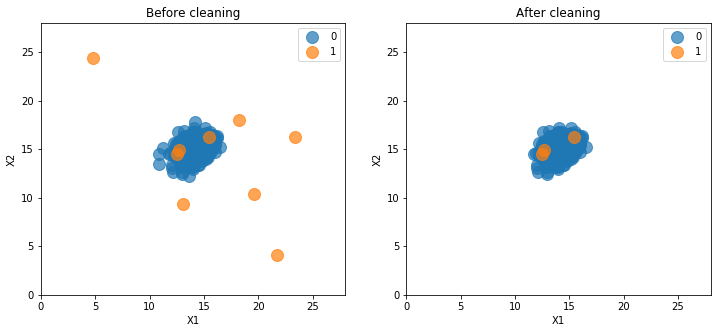

In [204]:
### Helper function to plot the result
def checkResult(data, df_no_outliers):
    """Function to plot the data before and after remove outliers
    Args: data (df), df_no_outliers (df)"""
    
    plt.figure(figsize = [12, 5])
    plt.subplot(1, 2, 1)
    plt.title("Before cleaning")
    plotScatter(data)
    plt.subplot(1, 2, 2)
    plotScatter(df_no_outliers)
    plt.title("After cleaning")
    
# plot the result
checkResult(data, df_no_outliers)

<a id='detect_remove_sklearn'></a>

### 2.4. OUTLIER DETECTION AND REMOVAL - SCIKIT-LEARN

<a id='EllipticEnvelope'></a>
#### 2.4.1. ELLIPTIC ENVELOPE
- Fit a multivariate gaussian distribution to the dataset.
- Tuning parameter: **contamination** the percentage of observations considered as outliers.

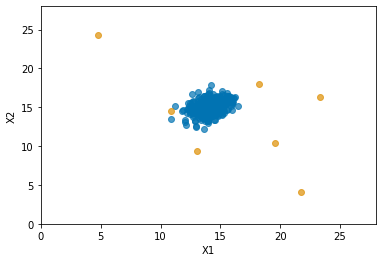

In [162]:
# import Elliptic Envelope
from sklearn.covariance import EllipticEnvelope

# set up and fit X feature (304,2)
ee = EllipticEnvelope(contamination = 0.02, random_state = 42)
y_pred = ee.fit_predict(X,y)
labels = []
for x in y_pred:
    if x == 1:
        labels.append(0)
    else:
        labels.append(1)
        
plotCluster(labels, X)

In [163]:
### Obtain the outliers as dataframe
extractOutliers(labels, data)

,X1,X2,y
147,10.859401,14.479144,0
300,13.079310,9.347878,1
301,21.727134,4.126232,1
303,19.582573,10.411619,1
304,23.339868,16.298874,1
305,18.261188,17.978309,1
306,4.752613,24.350407,1


In [164]:
### Remove the outliers from dataframe
df_no_outliers = removeOutliers(labels, data)

#### CHECKING THE RESULT

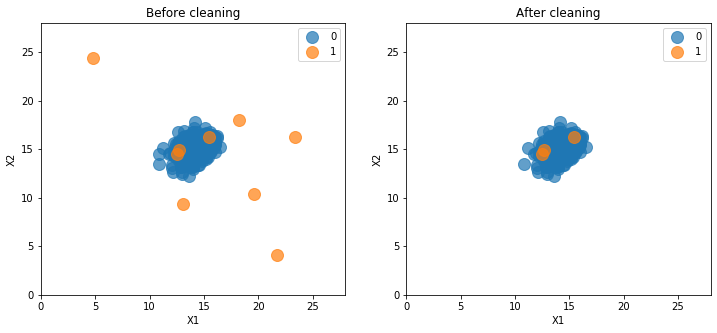

In [165]:
checkResult(data, df_no_outliers)

<a id='DBSCAN'></a>
#### 2.4.2. DBSCAN

- DBSCAN is a clustering algorithm that clusters points together. Outliers are points that do not belong to a cluster.
- Use DBSCAN to set up the cluster and predict the outliers.
- The parameter that need to be tuned: epsilon distance **eps** (distance of each point in the cluster). 

In [82]:
# import DBSCAN
from sklearn.cluster import DBSCAN
# set up and fit X feature (304,2)
dbscan = DBSCAN(eps = 1) # A little tricky to tune eps
dbscan.fit(X)

DBSCAN(eps=1)

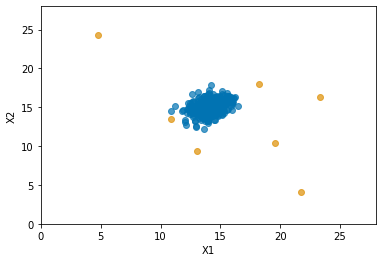

In [98]:
### Plot to see the result of DBSCAN
palette = sns.color_palette('colorblind', 10)
def plotCluster(pred, X):
    """Function to plot """
    colors = [palette[0], palette[1]] #sns.color_palette('colorblind',10)
    for i, val in enumerate(pred):
        plt.scatter(X[i][0], X[i][1], color = colors[val], alpha = 0.7)
    plt.xlim(0, 28)
    plt.ylim(0, 28)
    plt.xlabel('X1')
    plt.ylabel('X2')
### the predicted outliers will be in the dbscan.labels_     
plotCluster(dbscan.labels_, X)
# The performance is quite good.

In [117]:
### Obtain the outliers as dataframe
def extractOutliers(ypred, data):
    """Extract the outliers
    Args: ypred(list), data (df)
    Return outlier(df)"""
    indices = []
    for i, x in enumerate(ypred):
        if x != 0:
             indices.append(i)
    outliers = data.iloc[indices]
    return outliers

extractOutliers(dbscan.labels_, data)

,X1,X2,y
170,10.882213,13.461662,0
300,13.079310,9.347878,1
301,21.727134,4.126232,1
303,19.582573,10.411619,1
304,23.339868,16.298874,1
305,18.261188,17.978309,1
306,4.752613,24.350407,1


In [125]:
### Remove the outliers from dataframe
def removeOutliers(labels, data):
    """Drop the outliers from the dataframe 
    Args: labels(list), data (df)
    Return df_no_outliers (df)"""
    
    indices = []
    for i, x in enumerate(labels):
        if x != 0:
             indices.append(i)
    df_no_outliers = data.drop(indices, axis = 0)
    return df_no_outliers

df_no_outliers = removeOutliers(dbscan.labels_, data)

#### CHECKING THE RESULT

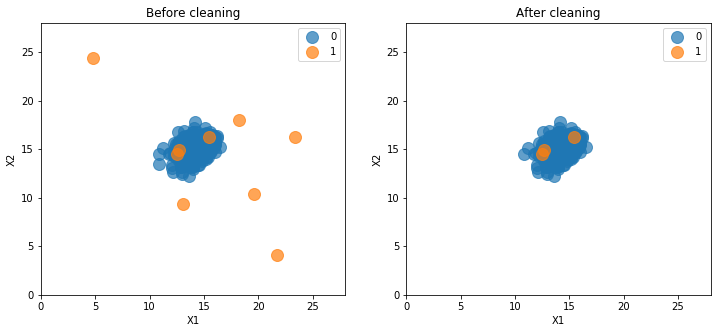

In [126]:
checkResult(data, df_no_outliers)

<a id='IsolationForest'></a>
#### 2.4.3. ISOLATION FOREST

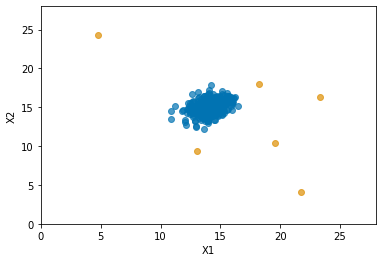

In [115]:
# import ISOLATION FOREST
from sklearn.ensemble import IsolationForest

# set up and fit X feature (304,2)
#iso = IsolationForest(contamination = 'auto', behaviour="new", random_state = 42)
## Tune the contamination value [0, 0.5]
iso = IsolationForest(contamination = 0.018, random_state = 42)
y_pred = iso.fit_predict(X,y)
labels = []
for x in y_pred:
    if x == 1:
        labels.append(0)
    else:
        labels.append(1)
        
plotCluster(labels, X)

In [122]:
### Obtain the outliers as dataframe
extractOutliers(labels, data)

,X1,X2,y
300,13.079310,9.347878,1
301,21.727134,4.126232,1
303,19.582573,10.411619,1
304,23.339868,16.298874,1
305,18.261188,17.978309,1
306,4.752613,24.350407,1


In [127]:
### Remove the outliers from dataframe
df_no_outliers = removeOutliers(labels, data)

#### CHECKING THE RESULT

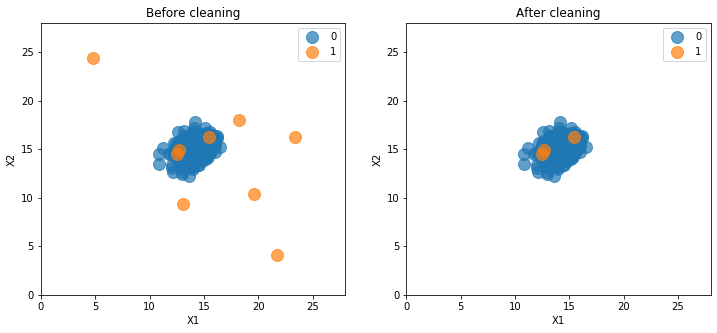

In [128]:
checkResult(data, df_no_outliers)

<a id='LocalOutlierFactor'></a>
#### 2.4.4. LOCAL OUTLIER FACTOR

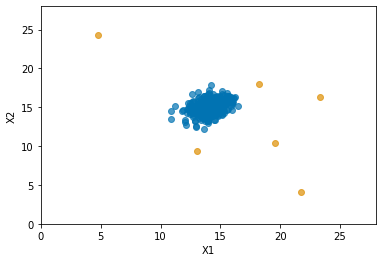

In [146]:
# import LocalOutlierFactor
from sklearn.neighbors import LocalOutlierFactor

# set up and fit X feature (304,2)
lof = LocalOutlierFactor(contamination = 0.018)
y_pred = lof.fit_predict(X,y)
labels = []
for x in y_pred:
    if x == 1:
        labels.append(0)
    else:
        labels.append(1)
        
plotCluster(labels, X)

In [142]:
### Obtain the outliers as dataframe
extractOutliers(labels, data)

,X1,X2,y
300,13.079310,9.347878,1
301,21.727134,4.126232,1
303,19.582573,10.411619,1
304,23.339868,16.298874,1
305,18.261188,17.978309,1
306,4.752613,24.350407,1


In [143]:
### Remove the outliers from dataframe
df_no_outliers = removeOutliers(labels, data)

#### CHECKING THE RESULT

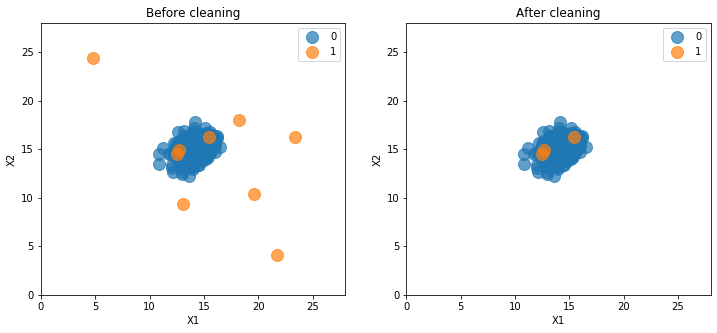

In [144]:
checkResult(data, df_no_outliers)

<a id='linear_regression'></a>

## 3. EXAMPLE DATASET 2 - SIMPLE LINEAR REGRESSION PROBLEM

#### OUTLIER REMOVAL STRATEGY USING LINEAR REGRESSION

- Including 3 steps: 
    + Step 1: Train the data
    + Step 2: Remove points with largest residual error (|real_val - predicted_val|)(~ 10% out the data points)
    + Step 3: Re-train again and compare the r2 score of the set.

In [175]:
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
### Load and transform data
ages = pickle.load( open("data/practice_outliers_ages.pkl", "rb") )
net_worths = pickle.load( open("data/practice_outliers_net_worths.pkl", "rb") )

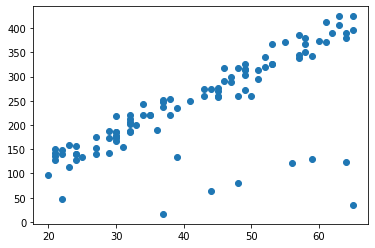

In [176]:
plt.scatter(ages, net_worths)
plt.show()

In [183]:
### Process the data for ML
ages = np.reshape(np.array(ages),(len(ages), 1))
net_worths = np.reshape(np.array(net_worths), (len(net_worths), 1))

###  Step 1: Train the data
def fit_plot_data(X1, X2):
    """Fit the data using Linear Regression Approach
    Plot the data with the predicted line"""
    
    ### Fit the data
    reg = LinearRegression()
    reg.fit(X1, X2)
    print("Slope:", reg.coef_)
    print("Intercept:", reg.intercept_)
    print("r2 score, data:", reg.score(X1, X2))
    ### Plot the data
    plt.scatter(X1, X2, color = "blue", alpha = 0.5)
    plt.plot(X1, reg.predict(X1))
    plt.show()
    return reg

Slope: [[5.23059872]]
Intercept: [20.81754227]
r2 score, data: 0.5248005763036859


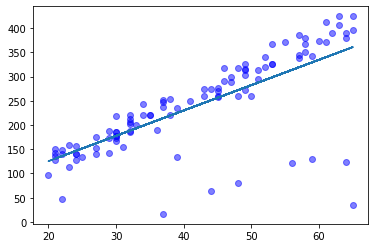

In [184]:
reg = fit_plot_data(ages, net_worths)

Slope: [[6.36612435]]
Intercept: [-7.29659469]
r2 score, data: 0.954451366492576


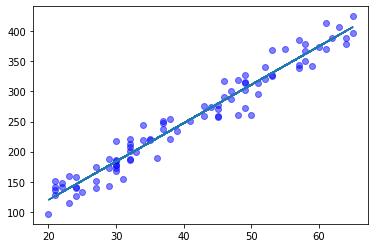

In [186]:
### Step 2: Remove points with largest residual error (|real_val - predicted_val|)(~ 10% out the data points)
cleaned_data = []
preds = reg.predict(ages)
for i in range(len(preds)):
    error = abs(preds.item(i) - net_worths.item(i))
    cleaned_data.append([ages.item(i), net_worths.item(i), error])
### sort the cleaned_data according to the residual error
cleaned_data.sort(key = lambda x: x[2])
# remove the 10% bottom of the data 
cleaned_data = cleaned_data[:len(ages) - int(len(ages)/10)]
ages, net_worths, _ = zip(*cleaned_data)
ages = np.reshape(np.array(ages), (len(ages),1))
net_worths = np.reshape(np.array(net_worths), (len(net_worths),1))

### Step 3: Re-train again and compare the r2 score, linear regression line of the set.
reg2 = fit_plot_data(ages, net_worths)
# => better r2 score, good fit to the data

<a id='multivariate_outlier'></a>
## 4. EXAMPLE DATASET 3 - MULTIVARIATE OUTLIER DETECTION

### 4.1. INTRODUCTION

- Anomaly detection - supervised dataset from the file `data/anomaly_detection2.mat`.
- X: 11 features from 1 to 11, y: binary class (0: normal and 1: anomaly observations).

In [209]:
### Load and process the data
mat2 = scipy.io.loadmat('data/anomaly_detection2.mat')
#access data through mat['X'] (or mat['Xval']) and mat['y']
X = mat2['Xval']
y = mat2['yval']
print(X.shape, y.shape)
### Make the dataframe for easy visualization
colnames = ['X'+str(i) for i in range(1, len(X[0]) + 1)]
data2 = pd.DataFrame(X, columns = colnames)
data2['y'] = y
data2.head(3)

(100, 11) (100, 1)


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,y
0,18.271283,-12.359268,5.000970,1.611472,1.088592,29.314410,-8.313531,36.438338,-9.476679,-25.928183,7.108628,1
1,-3.193070,-19.705821,6.528556,-21.570858,3.050556,23.477503,-1.133420,12.688409,-10.968301,-1.198666,1.908441,0
2,-5.256678,-12.918720,25.435141,-7.231568,3.647838,12.366550,-6.512076,8.750902,-0.768755,-3.261094,13.729474,0


In [215]:
print("Number of \"abnomaly : normal\" observation: {} : {}".format(data2.y.value_counts().values[1], data2.y.value_counts().values[0]))

Number of "abnomaly : normal" observation: 10 : 90


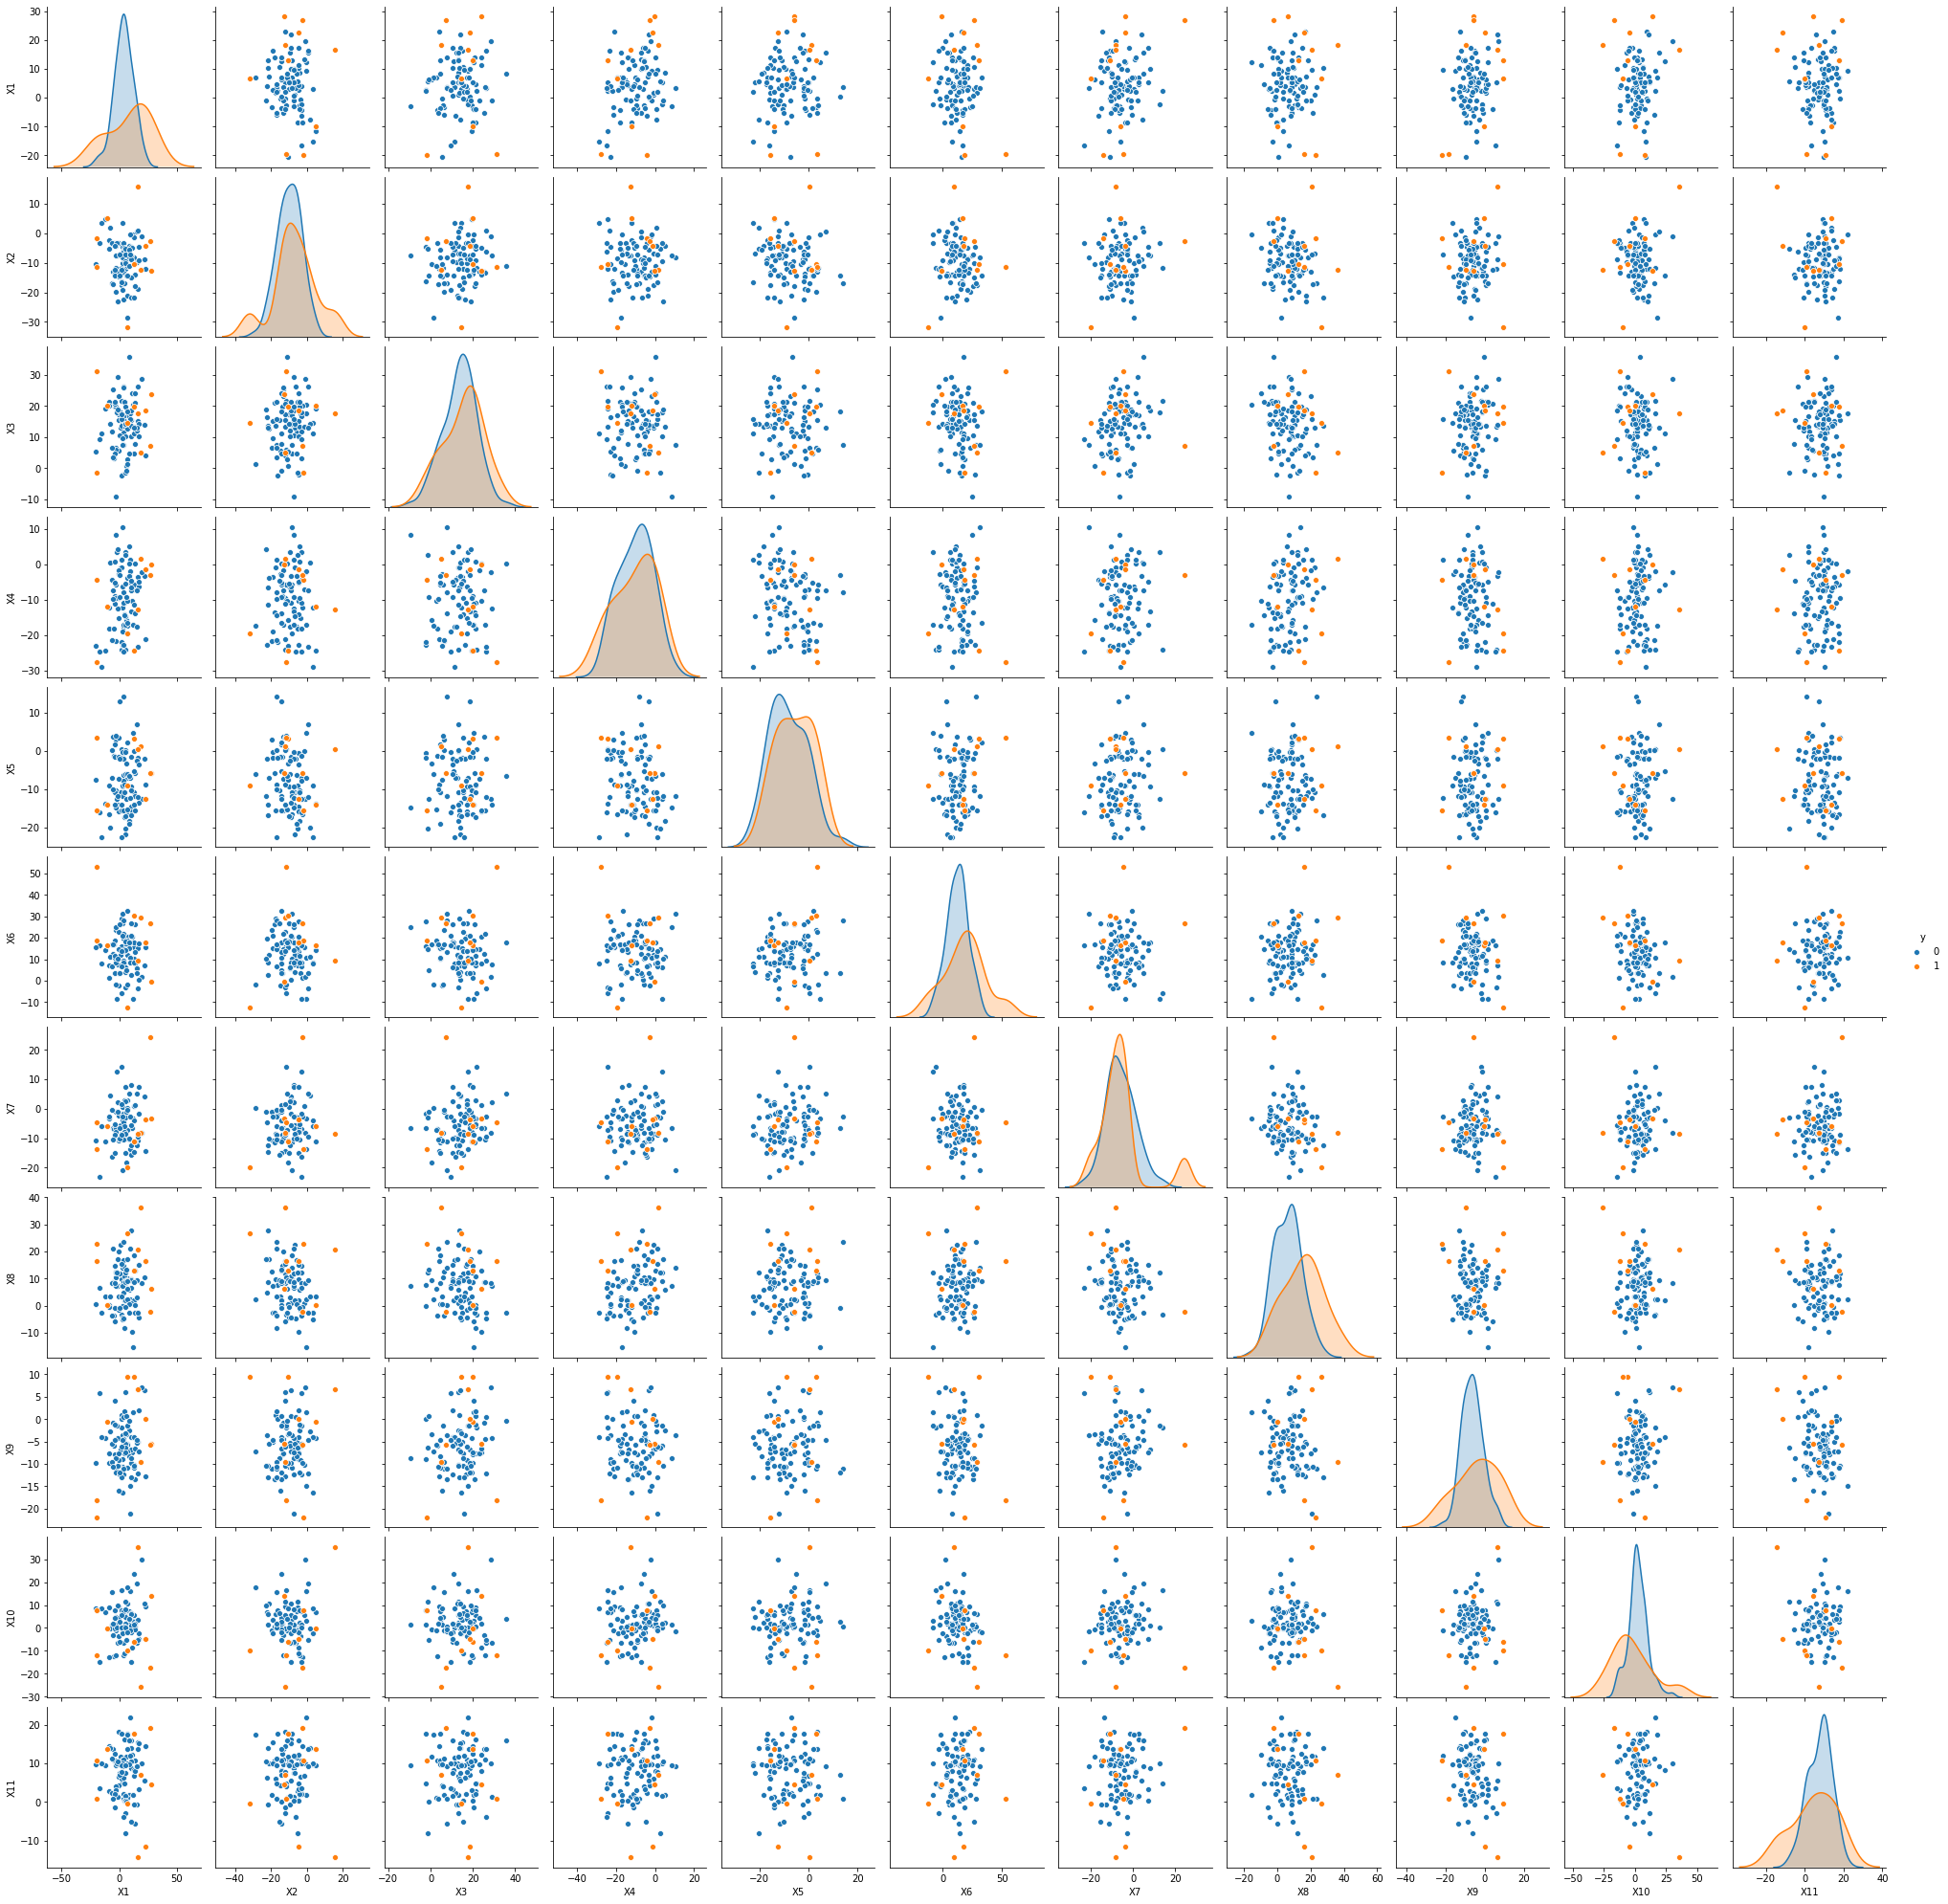

In [188]:
sns.pairplot(data2, hue = 'y')
plt.show()

### 4.2. OUTLIER DETECTION AND REMOVAL USING THE TUCKEY METHOD

In [205]:
### Using the function created in Session 2.3
df_no_outliers = removeOutliers_Tuckey(data2, data2.shape[1] - 1)
df_no_outliers.shape

Condition to remove outliers: ((X1 >= -17.889174597368438) and (X1 <= 27.289080474236513))and((X2 >= -28.47775398716442) and (X2 <= 9.933070952235397))and((X3 >= -7.0583283392107745) and (X3 <= 35.6962005344072))and((X4 >= -38.08212509844219) and (X4 <= 17.868197804775694))and((X5 >= -32.40117109493772) and (X5 <= 16.718955171195503))and((X6 >= -10.199857874107565) and (X6 <= 35.54298515624471))and((X7 >= -23.234606538635454) and (X7 <= 11.123684754154281))and((X8 >= -18.320496596082403) and (X8 <= 31.344640754383683))and((X9 >= -22.010821153045462) and (X9 <= 9.500147824396395))and((X10 >= -16.159395342084874) and (X10 <= 20.687709072936023))and((X11 >= -11.945709406103123) and (X11 <= 25.742939738044576))


(84, 12)

In [216]:
### Evaluate the result
print("Number of \"abnomaly : normal\" observation: {} : {}".format(df_no_outliers.y.value_counts().values[1], df_no_outliers.y.value_counts().values[0]))

Number of "abnomaly : normal" observation: 3 : 81
